In [ ]:
# импорт библиотек

import os
os.environ["KERAS_BACKEND"] = "torch"

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

import keras
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import keras, torch
from transformers import AutoModel
from transformers import AutoTokenizer

from tqdm.auto import tqdm
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score

# Подготовка датасета

In [ ]:
data = pd.read_csv("lenta_sample.csv")

texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

# Общие классы и функции для моделей

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, MAX_LEN, texts, targets):

        self.tokenizer = tokenizer
        self.texts = [torch.LongTensor(tokenizer.encode(t)[:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True,
                                                     padding_value=self.tokenizer.pad_token_id)

        self.MAX_LEN = MAX_LEN
        self.length = len(texts)

        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y

    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [ ]:
# функции для обучения
def train(model, iterator, optimizer, criterion, print_every=1000):

    epoch_loss = []
    epoch_f1 = []

    model.train()

    for i, (texts, ys) in enumerate(iterator):

        optimizer.zero_grad()
        predictions = model(texts.to(device)).squeeze()
        loss = criterion(predictions, ys.to(device))



        loss.backward()
        optimizer.step()
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()

        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))

        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')

    return np.mean(epoch_f1)

def evaluate(model, iterator, criterion):

    epoch_loss = []
    epoch_f1 = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:

            predictions = model(texts.to(device)).squeeze()
            loss = criterion(predictions, ys.to(device))
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()


            epoch_loss.append(loss.item())
            epoch_f1.append(f1_score(y_true, preds, average="micro"))

    return np.mean(epoch_f1)# / len(iterator)

def predict(model, iterator):

    preds = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:
            predictions = model(texts.to(device)).squeeze()
            ys = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            preds.extend(ys)

    return preds

In [ ]:
class CLF(nn.Module):

    def __init__(self, pretrained_model, num_classes, avg_pool=False):
        super().__init__()
        self.tokenizer = tokenizer # токенизатор
        self.pretrained_model = pretrained_model # предобученная модель
        self.drop = nn.Dropout(0.3) # добавим дропаут чтобы не переобучалось
        self.fc = nn.Linear(768, num_classes)
        self.act = nn.LogSoftmax(1)

    def forward(self, texts):

        mask = (texts != tokenizer.pad_token_id).long()

        # прогоняем через BERT
        hidden = self.pretrained_model(texts, attention_mask=mask)[0]

        if self.avg_pool == False:
            # берем самое первое состояние и применяем к нему линейный слой и активацию
            to_drop = hidden[:,0]
        elif self.avg_pool == True:
            to_drop = hidden.mean(1)

        outputs=self.act(self.fc(self.drop(to_drop)))

        return outputs

# Дообучение modernbert-base целиком

## Подготовка

In [ ]:
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_modernbert = AutoModel.from_pretrained(model_id)
MAX_LEN = 512
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_modernbert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

## Обучение

In [ ]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0


W0405 15:30:31.241000 2260 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


Eval -  0.06666666666666667
1
Eval -  0.06458333333333333
2
Eval -  0.0625
3
Eval -  0.06666666666666667
4
Eval -  0.03125
5
Eval -  0.06666666666666667
6
Eval -  0.06458333333333333
7
Eval -  0.09583333333333333
8
Eval -  0.09791666666666667
9
Eval -  0.09583333333333333
10
Eval -  0.06458333333333333
11
Eval -  0.13125
12
Eval -  0.09583333333333333
13
Eval -  0.1625
14
Eval -  0.19166666666666665
15
Eval -  0.19791666666666666
16
Eval -  0.22708333333333333
17
Eval -  0.09583333333333333
18
Eval -  0.1625
19
Eval -  0.18958333333333333
20
Eval -  0.06458333333333333
21
Eval -  0.22291666666666665
22
Eval -  0.22708333333333333
23
Eval -  0.19166666666666665
24
Eval -  0.12708333333333333
25
Eval -  0.19375
26
Eval -  0.15625
27
Eval -  0.19791666666666666
28
Eval -  0.225
29
Eval -  0.16041666666666665


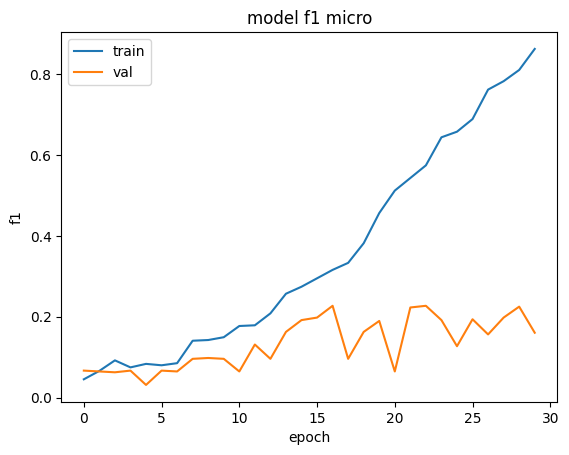

In [ ]:
# визуализация
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title("model f1 micro")
plt.ylabel("f1")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

# Дообучение rumodernbert-base

## Подготовка

In [ ]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_modernbert = AutoModel.from_pretrained(model_id)
MAX_LEN = 512
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_modernbert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

## Обучение

In [ ]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.0625
1
Eval -  0.03125
2
Eval -  0.0625
3
Eval -  0.0625
4
Eval -  0.2520833333333333
5
Eval -  0.2583333333333333
6
Eval -  0.06458333333333333
7
Eval -  0.09791666666666667
8
Eval -  0.12708333333333333
9
Eval -  0.16041666666666665
10
Eval -  0.2895833333333333
11
Eval -  0.32291666666666663
12
Eval -  0.48125
13
Eval -  0.4145833333333333
14


KeyboardInterrupt: 

In [ ]:
# визуализация
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title("model f1 micro")
plt.ylabel("f1")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

# Дообучение modernbert-base с заморозкой

## Подготовка

In [ ]:
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)

for param in model_modernbert.parameters():
    param.requires_grad = False

model_modernbert = AutoModel.from_pretrained(model_id)
MAX_LEN = 512
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_modernbert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

## Обучение

In [ ]:
f1s = []
f1s_eval = []

for i in range(40):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

In [ ]:
# визуализация
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title("model f1 micro")
plt.ylabel("f1")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

# Дообучение rumodernbert-base с заморозкой (cls)

## Подготовка

In [ ]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)

for param in model_modernbert.parameters():
    param.requires_grad = False

model_modernbert = AutoModel.from_pretrained(model_id)
MAX_LEN = 512
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_modernbert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

## Обучение

In [ ]:
f1s = []
f1s_eval = []

for i in range(40):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

# Дообучение rumodernbert-base с заморозкой (усредненный hidden_state)

## Подготовка

In [ ]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_modernbert = AutoModel.from_pretrained(model_id)
MAX_LEN = 512
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_modernbert, len(label2id), avg_pool=True)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

## Обучение

In [ ]:
f1s = []
f1s_eval = []

for i in range(40):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

In [ ]:
# визуализация
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title("model f1 micro")
plt.ylabel("f1")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))